In [8]:
!pwd

/n/holylabs/LABS/sitanc_lab/Users/mfli/critical-windows-lm/notebooks


In [9]:
import sys
import os
sys.path.append(os.path.abspath('../'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
import os

from utils.plot_utils import compute_ci

pd.set_option('display.max_rows', 500)

## CoT over 10k points

It isimportant to note that for the results are sensitive to whether we filter for NANs, i.e. directly asking early one tends to results in NaN values

In [2]:
base_dir = "/n/holylabs/LABS/sitanc_lab/Users/mfli/critical-windows-lm/results/NoiseDenoise"
datasets = [d for d in os.listdir(base_dir) if d.startswith("NoiseDenoise_model=meta-llama-Llama-3.1-8B-Instruct_dataset=") and d.endswith("_nsamples=10000_num_per_noise=1")]

real_dataset_names = [d.split("_dataset=")[1].split("_split=")[0] for d in datasets]
dataset_names = ["MATH","AQUA-RAT","LogiQA","ARC Challenge", "ARC Easy", "MMLU", "TruthfulQA"]
print(real_dataset_names)

print(dataset_names)

['competition_math', 'deepmind-aqua_rat', 'allenai-ai2_arc-ARC-Easy', 'truthfulqa-truthful_qa', 'cais-mmlu', 'lucasmccabe-logiqa', 'allenai-ai2_arc-ARC-Challenge']
['MATH', 'AQUA-RAT', 'LogiQA', 'ARC Challenge', 'ARC Easy', 'MMLU', 'TruthfulQA']


In [3]:
combined_df = pd.DataFrame()

for dataset, dataset_name in zip(datasets, dataset_names):
    file_path = os.path.join(base_dir, dataset, "eval_noisedenoise.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df['dataset_source'] = dataset_name
        combined_df = pd.concat([combined_df, df], ignore_index=True)

print("Before dropping NA for orig_answer")
print(combined_df.shape)

combined_df = combined_df[~combined_df.orig_ans_format.isna()]
print("After dropping NA for orig_answer")
print(combined_df.shape)


Before dropping NA for orig_answer
(234378, 20)
After dropping NA for orig_answer
(233826, 20)


In [4]:
display(combined_df.head())

problem formatted_answer  stop_frac  no  \
0  Evaluate $\log_432$.      \frac{5}{2}       0.05   0   
1  Evaluate $\log_432$.      \frac{5}{2}       0.10   0   
2  Evaluate $\log_432$.      \frac{5}{2}       0.30   0   
3  Evaluate $\log_432$.      \frac{5}{2}       0.50   0   
4  Evaluate $\log_432$.      \frac{5}{2}       0.70   0   

                        orig_ans_string orig_ans_format  \
0  The answer is $\boxed{\frac{5}{2}}$.     \frac{5}{2}   
1  The answer is $\boxed{\frac{5}{2}}$.     \frac{5}{2}   
2  The answer is $\boxed{\frac{5}{2}}$.     \frac{5}{2}   
3  The answer is $\boxed{\frac{5}{2}}$.     \frac{5}{2}   
4  The answer is $\boxed{\frac{5}{2}}$.     \frac{5}{2}   

                                    stump_ans_string stump_ans_format  \
0  To evaluate $\log_432$, we can use the change ...              NaN   
1  To evaluate $\log_432$, we can use the change ...              NaN   
2  To evaluate $\log_432$, we can use the change ...              NaN   
3  To evaluate $\log_432$, we can use the change ...              NaN   
4               The answer is $\boxed{\frac{5}{2}}$.      \frac{5}{2}   

  no_deno_ans_format                    no_deno_ans_string  is_consistent  \
0        \frac{5}{2}  The answer is $\boxed{\frac{5}{2}}$.           True   
1        \frac{5}{2}  The answer is $\boxed{\frac{5}{2}}$.           True   
2        \frac{5}{2}  The answer is $\boxed{\frac{5}{2}}$.           True   
3        \frac{5}{2}  The answer is $\boxed{\frac{5}{2}}$.           True   
4        \frac{5}{2}  The answer is $\boxed{\frac{5}{2}}$.           True   

   is_right  orig_is_right  stump_is_right  is_stump  stump_is_consistent  \
0      True           True           False     False                False   
1      True           True           False     False                False   
2      True           True           False     False                False   
3      True           True           False     False                False   
4      True           True            True      True                 True   

                                    stump_string_ans  \
0  <|begin_of_text|><|start_header_id|>system<|en...   
1  <|begin_of_text|><|start_header_id|>system<|en...   
2  <|begin_of_text|><|start_header_id|>system<|en...   
3  <|begin_of_text|><|start_header_id|>system<|en...   
4  <|begin_of_text|><|start_header_id|>system<|en...   

                                  no_deno_string_ans  \
0  <|begin_of_text|><|start_header_id|>system<|en...   
1  <|begin_of_text|><|start_header_id|>system<|en...   
2  <|begin_of_text|><|start_header_id|>system<|en...   
3  <|begin_of_text|><|start_header_id|>system<|en...   
4  <|begin_of_text|><|start_header_id|>system<|en...   

                                     orig_string_ans dataset_source  
0  <|begin_of_text|><|start_header_id|>system<|en...           MATH  
1  <|begin_of_text|><|start_header_id|>system<|en...           MATH  
2  <|begin_of_text|><|start_header_id|>system<|en...           MATH  
3  <|begin_of_text|><|start_header_id|>system<|en...           MATH  
4  <|begin_of_text|><|start_header_id|>system<|en...           MATH

In [5]:
display(combined_df
        .groupby(["dataset_source", "stop_frac"])[["is_right"]].mean().reset_index()
 .pivot(index="dataset_source", columns="stop_frac", values="is_right")
 .join(combined_df.groupby("dataset_source")["orig_is_right"].mean())
)


0.05       0.1       0.3       0.5       0.7       0.9  \
dataset_source                                                               
AQUA-RAT        0.701795  0.702798  0.693974  0.694074  0.702597  0.712123   
ARC Challenge   0.679315  0.675643  0.685435  0.687882  0.676867  0.678091   
ARC Easy        0.827248  0.826248  0.821446  0.821046  0.824547  0.822547   
LogiQA          0.941804  0.944025  0.938250  0.940027  0.940915  0.946690   
MATH            0.690012  0.687458  0.683291  0.689206  0.692297  0.697406   
MMLU            0.514441  0.520000  0.508610  0.515254  0.515390  0.520814   
TruthfulQA      0.879357  0.881144  0.879357  0.876676  0.884718  0.879357   

                orig_is_right  
dataset_source                 
AQUA-RAT             0.714128  
ARC Challenge        0.668299  
ARC Easy             0.825748  
LogiQA               0.946246  
MATH                 0.697674  
MMLU                 0.517153  
TruthfulQA           0.874888

In [6]:
## Stump over stop_frac
display(combined_df
 .groupby(["dataset_source", "stop_frac"])["stump_is_right"].mean().reset_index()
 .pivot(index="dataset_source", columns="stop_frac", values="stump_is_right")
 .join(combined_df.groupby("dataset_source")["orig_is_right"].mean())
)

0.05       0.1       0.3       0.5       0.7       0.9  \
dataset_source                                                               
AQUA-RAT        0.061265  0.115412  0.237140  0.333099  0.406096  0.466159   
ARC Challenge   0.512852  0.580171  0.632803  0.640147  0.652387  0.662179   
ARC Easy        0.763929  0.796339  0.821646  0.824247  0.829149  0.828949   
LogiQA          0.346068  0.756553  0.941804  0.941359  0.939138  0.946246   
MATH            0.173545  0.224896  0.296142  0.336470  0.399247  0.586100   
MMLU            0.453153  0.507254  0.515661  0.518102  0.518102  0.520000   
TruthfulQA      0.345845  0.699732  0.850760  0.853441  0.860590  0.873995   

                orig_is_right  
dataset_source                 
AQUA-RAT             0.714128  
ARC Challenge        0.668299  
ARC Easy             0.825748  
LogiQA               0.946246  
MATH                 0.697674  
MMLU                 0.517153  
TruthfulQA           0.874888

In [7]:
## is_consistent over stop_frac
display(combined_df
 .groupby(["dataset_source", "stop_frac"])["is_consistent"].mean().reset_index()
 .pivot(index="dataset_source", columns="stop_frac", values="is_consistent")
)

stop_frac           0.05      0.10      0.30      0.50      0.70      0.90
dataset_source                                                            
AQUA-RAT        0.714329  0.721247  0.756843  0.790635  0.823122  0.873458
ARC Challenge   0.762546  0.780906  0.807834  0.853121  0.877601  0.954712
ARC Easy        0.846654  0.854356  0.874362  0.899470  0.932680  0.967290
LogiQA          0.939582  0.944913  0.952021  0.973789  0.977788  0.995113
MATH            0.610700  0.619035  0.648878  0.696330  0.755209  0.851593
MMLU            0.656271  0.647186  0.693831  0.781831  0.858712  0.934102
TruthfulQA      0.874888  0.889187  0.907060  0.934763  0.949955  0.974978

In [8]:
## stump_is_consistent over stop_frac
display(combined_df
 .groupby(["dataset_source", "stop_frac"])["stump_is_consistent"].mean().reset_index()
 .pivot(index="dataset_source", columns="stop_frac", values="stump_is_consistent")
)

stop_frac           0.05      0.10      0.30      0.50      0.70      0.90
dataset_source                                                            
AQUA-RAT        0.084829  0.152612  0.305625  0.414319  0.505264  0.594605
ARC Challenge   0.586291  0.698898  0.773562  0.809058  0.864137  0.931457
ARC Easy        0.787336  0.823047  0.859258  0.879264  0.905472  0.953186
LogiQA          0.348290  0.762772  0.946246  0.960018  0.970235  0.987117
MATH            0.145181  0.190348  0.263342  0.310794  0.395080  0.637855
MMLU            0.565966  0.634983  0.660610  0.725017  0.804068  0.895322
TruthfulQA      0.347632  0.716711  0.873101  0.892761  0.925827  0.964254

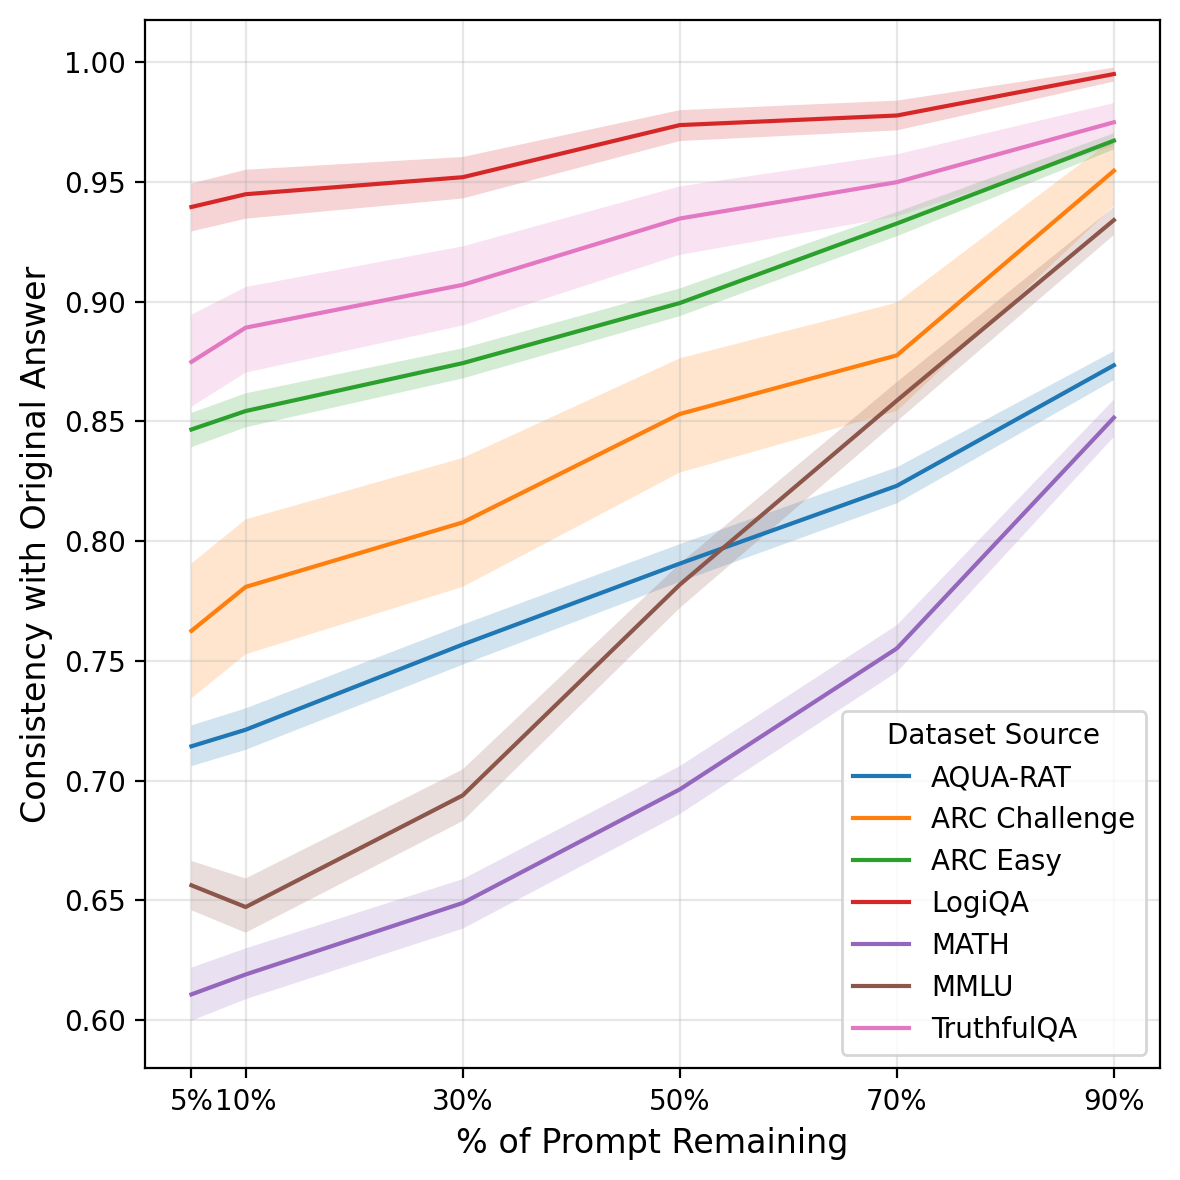

In [ ]:
# Preparing data for plotting
plot_data = []
for (dataset_source, stop_frac), group in combined_df.groupby(["dataset_source", "stop_frac"]):
    mean, lower, upper = compute_ci(group["is_consistent"])
    plot_data.append({
        "dataset_source": dataset_source,
        "stop_frac": stop_frac,
        "mean": mean,
        "ci_lower": lower,
        "ci_upper": upper
    })

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)

# Create the plot
plt.figure(figsize=(6, 6),dpi=200)
for dataset in plot_df["dataset_source"].unique():
    data = plot_df[plot_df["dataset_source"] == dataset]
    plt.plot(data["stop_frac"], data["mean"], label=dataset)
    plt.fill_between(data["stop_frac"], data["ci_lower"], data["ci_upper"], alpha=0.2)

# Customize plot
plt.xlabel("% of Prompt Remaining", fontsize=12)
plt.ylabel("Consistency with Original Answer", fontsize=12)
plt.xticks(plot_df["stop_frac"].unique(), labels=[f"{int(x*100)}%" for x in plot_df["stop_frac"].unique()])
plt.legend(title="Dataset Source")
plt.grid(alpha=0.3)
plt.tight_layout()

# Show plot
plt.show()

Text(0.5, 1.0, 'Other Datasets')

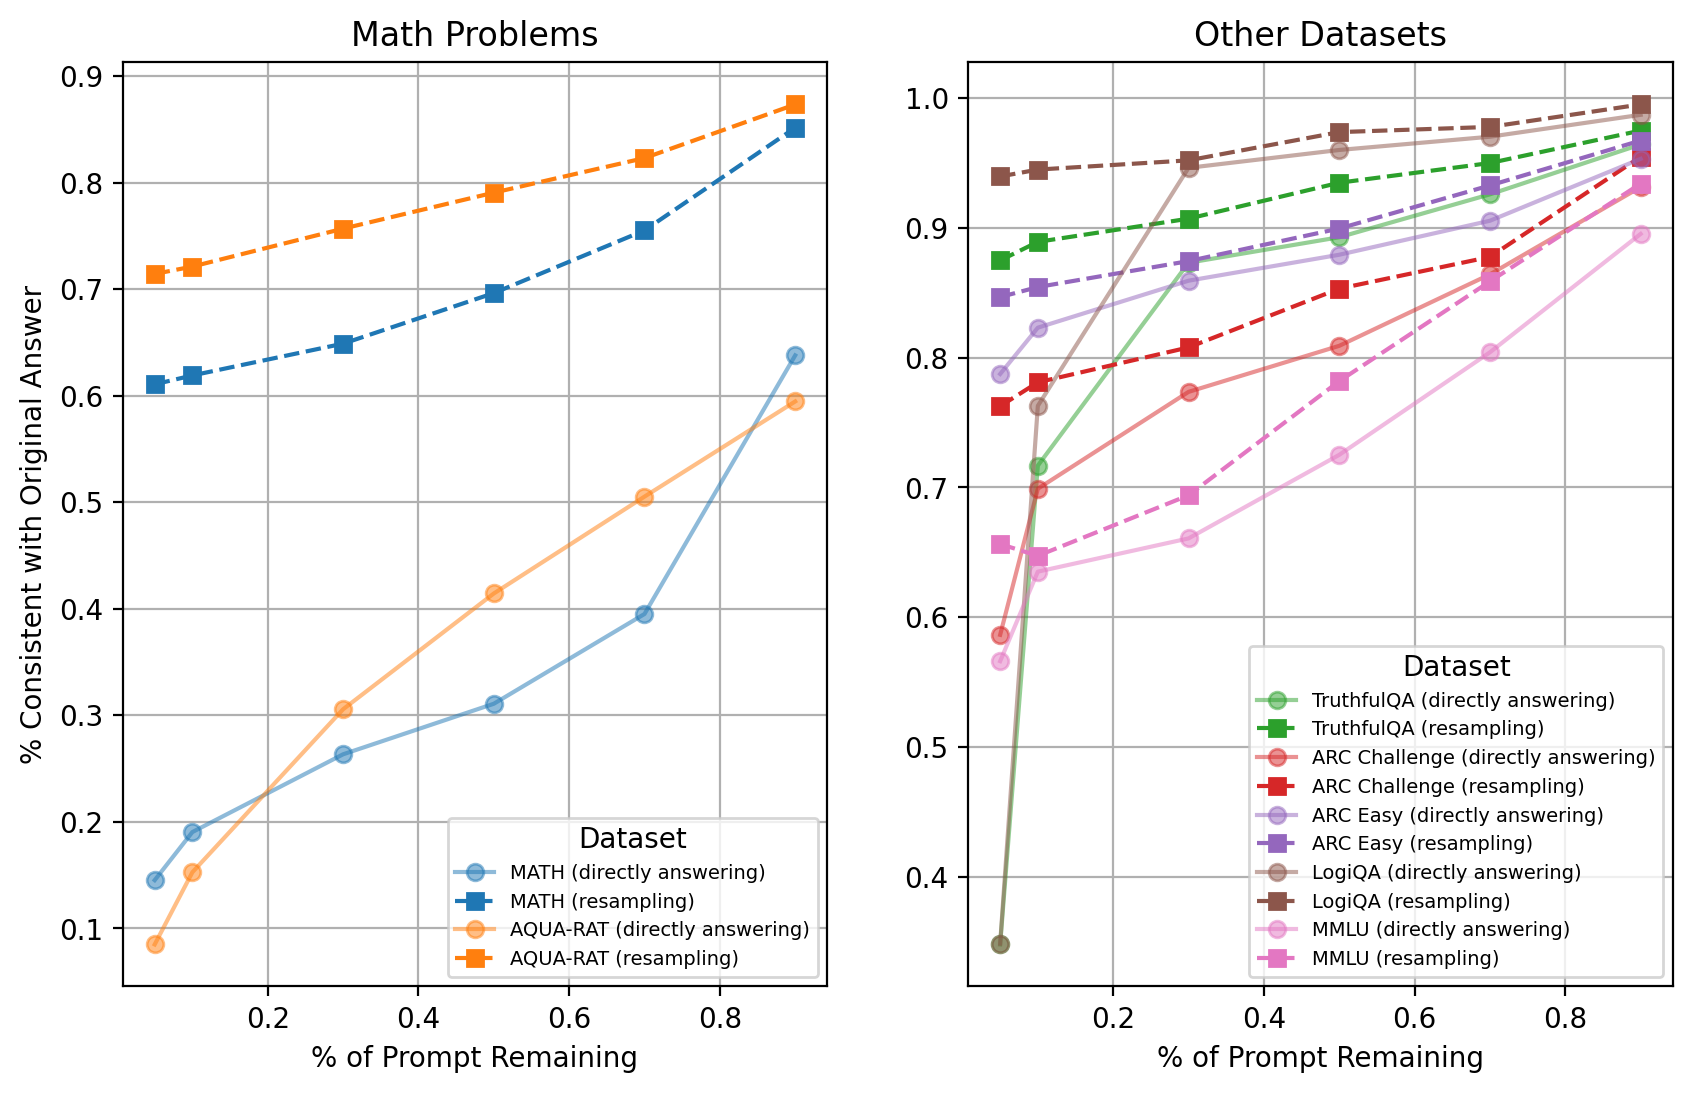

In [ ]:
# Compute the means grouped by dataset_source and stop_frac
stump_means = (combined_df
               .groupby(["dataset_source", "stop_frac"])["stump_is_consistent"]
               .mean()
               .reset_index())

not_stump_means = (combined_df
                   .groupby(["dataset_source", "stop_frac"])["is_consistent"]
                   .mean()
                   .reset_index())

# Merge the two datasets for easier plotting of arrows
merged_means = pd.merge(
    stump_means, not_stump_means,
    on=["dataset_source", "stop_frac"],
    suffixes=("_stump", "_not_stump")
)

# Set up the plot
fig, axs = plt.subplots(1,2,figsize=(10, 6), dpi=200)

# Assign colors for each dataset_source
colors = plt.cm.tab10(range(len(merged_means["dataset_source"].unique())))

# Plot for each dataset_source


for i, dataset in enumerate(["MATH",  "AQUA-RAT"]):
    subset = merged_means[merged_means["dataset_source"] == dataset]
    
    axs[0].plot(subset["stop_frac"], subset["stump_is_consistent"],alpha=0.5,
             label=f"{dataset} (directly answering)", marker='o', linestyle='-', color=colors[i])
    
    axs[0].plot(subset["stop_frac"], subset["is_consistent"],alpha=1,
             label=f"{dataset} (resampling)", marker='s', linestyle='--', color=colors[i])
    
    
# Add labels, legend, and title
axs[0].set_xlabel("% of Prompt Remaining")
axs[0].set_ylabel("% Consistent with Original Answer")
axs[0].set_title("Math Problems")
axs[0].legend(title="Dataset",fontsize=7)
axs[0].grid(True)

# Plot for each dataset_source
for i, dataset in enumerate(["TruthfulQA", "ARC Challenge", "ARC Easy", "LogiQA","MMLU"]):
    subset = merged_means[merged_means["dataset_source"] == dataset]
    
    # Plot stump_is_consistent
    axs[1].plot(subset["stop_frac"], subset["stump_is_consistent"],alpha=0.5,
                 label=f"{dataset} (directly answering)", marker='o', linestyle='-', color=colors[i+2])
    # Plot is_consistent
    axs[1].plot(subset["stop_frac"], subset["is_consistent"],alpha=1,
             label=f"{dataset} (resampling)", marker='s', linestyle='--', color=colors[i+2])
    
    # Draw arrows between points
#     for _, row in subset.iterrows():
#         axs[1].arrow(
#             row["stop_frac"], row["stump_is_consistent"],
#             0, row["is_consistent"] - row["stump_is_consistent"],
#             head_width=0.01, head_length=0.02, color=colors[i+4], alpha=1, length_includes_head=True
#         )

# Add labels, legend, and title
axs[1].set_xlabel("% of Prompt Remaining")
axs[1].grid(True)
axs[1].legend(title="Dataset",fontsize=7)
axs[1].set_title("Other Datasets")


## Conditioning on correctness 

Doesn't seem to be that meaningful because ``is_right`` only affects ``is_consistent`` through ``orig_is_right``?

In [11]:
correlations = (combined_df
                .groupby(["dataset_source", "stop_frac"])
                .apply(lambda x: x["is_right"].corr(x["is_consistent"]))
)

# Display the results
print(correlations)

dataset_source  stop_frac
AQUA-RAT        0.05         0.503848
                0.10         0.506324
                0.30         0.482287
                0.50         0.464361
                0.70         0.418159
                0.90         0.362171
ARC Challenge   0.05         0.349969
                0.10         0.378887
                0.30         0.331923
                0.50         0.272719
                0.70         0.292959
                0.90         0.139716
ARC Easy        0.05         0.444417
                0.10         0.436341
                0.30         0.419032
                0.50         0.378505
                0.70         0.302187
                0.90         0.229583
LogiQA          0.05         0.590037
                0.10         0.542621
                0.30         0.546908
                0.50         0.427012
                0.70         0.409696
                0.90         0.125160
MATH            0.05         0.719076
                0.10    

/tmp/ipykernel_3670898/2122935805.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x["is_right"].corr(x["is_consistent"]))


## Per example COT

In [12]:
base_dir = "/n/holylabs/LABS/sitanc_lab/Users/mfli/critical-windows-lm/results/NoiseDenoise"
datasets = [d for d in os.listdir(base_dir) if d.startswith("NoiseDenoise_model=meta-llama-Llama-3.1-8B-Instruct_dataset=") and d.endswith("_nsamples=400_num_per_noise=25")]

real_dataset_names = [d.split("_dataset=")[1].split("_split=")[0] for d in datasets]
dataset_names = ["MATH","AQUA-RAT","LogiQA","ARC Challenge", "ARC Easy", "MMLU", "TruthfulQA"]
print(real_dataset_names)

print(dataset_names)

['competition_math', 'deepmind-aqua_rat', 'lucasmccabe-logiqa', 'allenai-ai2_arc-ARC-Challenge', 'allenai-ai2_arc-ARC-Easy', 'cais-mmlu', 'truthfulqa-truthful_qa']
['MATH', 'AQUA-RAT', 'LogiQA', 'ARC Challenge', 'ARC Easy', 'MMLU', 'TruthfulQA']


In [13]:
combined_df = pd.DataFrame()

for dataset, dataset_name in zip(datasets, dataset_names):
    file_path = os.path.join(base_dir, dataset, "eval_noisedenoise.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df['dataset_source'] = dataset_name
        combined_df = pd.concat([combined_df, df], ignore_index=True)

print("Before dropping NA for orig_answer")
print(combined_df.shape)

combined_df = combined_df[~combined_df.orig_ans_format.isna()]
print("After dropping NA for orig_answer")
print(combined_df.shape)
display(combined_df.head())

Before dropping NA for orig_answer
(420000, 20)
After dropping NA for orig_answer
(419700, 20)


problem formatted_answer  stop_frac  no  \
0  Find $\sec 135^\circ.$        -\sqrt{2}       0.05   0   
1  Find $\sec 135^\circ.$        -\sqrt{2}       0.05   1   
2  Find $\sec 135^\circ.$        -\sqrt{2}       0.05   2   
3  Find $\sec 135^\circ.$        -\sqrt{2}       0.05   3   
4  Find $\sec 135^\circ.$        -\sqrt{2}       0.05   4   

              orig_ans_string orig_ans_format  \
0  The answer is $-\sqrt{2}$.       -\sqrt{2}   
1  The answer is $-\sqrt{2}$.       -\sqrt{2}   
2  The answer is $-\sqrt{2}$.       -\sqrt{2}   
3  The answer is $-\sqrt{2}$.       -\sqrt{2}   
4  The answer is $-\sqrt{2}$.       -\sqrt{2}   

                                    stump_ans_string stump_ans_format  \
0  To find $\sec 135^\circ$, we can use the defin...              NaN   
1  To find $\sec 135^\circ$, we can use the defin...              NaN   
2  To find $\sec 135^\circ$, we can use the defin...              NaN   
3  To find $\sec 135^\circ$, we can use the defin...              NaN   
4  To find $\sec 135^\circ$, we can use the defin...              NaN   

  no_deno_ans_format                  no_deno_ans_string  is_consistent  \
0          -\sqrt{2}  The answer is $\boxed{-\sqrt{2}}$.           True   
1          -\sqrt{2}          The answer is $-\sqrt{2}$.           True   
2          -\sqrt{2}          The answer is $-\sqrt{2}$.           True   
3          -\sqrt{2}          The answer is $-\sqrt{2}$.           True   
4          -\sqrt{2}          The answer is $-\sqrt{2}$.           True   

   is_right  orig_is_right  stump_is_right  is_stump  stump_is_consistent  \
0      True           True           False     False                False   
1      True           True           False     False                False   
2      True           True           False     False                False   
3      True           True           False     False                False   
4      True           True           False     False                False   

                                    stump_string_ans  \
0  <|begin_of_text|><|start_header_id|>system<|en...   
1  <|begin_of_text|><|start_header_id|>system<|en...   
2  <|begin_of_text|><|start_header_id|>system<|en...   
3  <|begin_of_text|><|start_header_id|>system<|en...   
4  <|begin_of_text|><|start_header_id|>system<|en...   

                                  no_deno_string_ans  \
0  <|begin_of_text|><|start_header_id|>system<|en...   
1  <|begin_of_text|><|start_header_id|>system<|en...   
2  <|begin_of_text|><|start_header_id|>system<|en...   
3  <|begin_of_text|><|start_header_id|>system<|en...   
4  <|begin_of_text|><|start_header_id|>system<|en...   

                                     orig_string_ans dataset_source  
0  <|begin_of_text|><|start_header_id|>system<|en...           MATH  
1  <|begin_of_text|><|start_header_id|>system<|en...           MATH  
2  <|begin_of_text|><|start_header_id|>system<|en...           MATH  
3  <|begin_of_text|><|start_header_id|>system<|en...           MATH  
4  <|begin_of_text|><|start_header_id|>system<|en...           MATH

In [14]:
## Probability noise vs denoise is the correct over stop_frac
display(combined_df
        .groupby(["dataset_source", "stop_frac"])[["is_right"]].mean().reset_index()
 .pivot(index="dataset_source", columns="stop_frac", values="is_right")
 .join(combined_df.groupby("dataset_source")["orig_is_right"].mean())
)


0.05       0.1       0.3       0.5       0.7       0.9  \
dataset_source                                                               
AQUA-RAT        0.687719  0.703358  0.684712  0.678596  0.700952  0.701654   
ARC Challenge   0.897600  0.899800  0.894700  0.885200  0.862300  0.892000   
ARC Easy        0.946600  0.948400  0.944100  0.944200  0.950900  0.945700   
LogiQA          0.525400  0.508100  0.518400  0.506800  0.491000  0.500300   
MATH            0.713684  0.705263  0.715890  0.698346  0.724211  0.726717   
MMLU            0.825900  0.816900  0.841300  0.832300  0.827000  0.820000   
TruthfulQA      0.665200  0.690600  0.672400  0.705600  0.698200  0.705500   

                orig_is_right  
dataset_source                 
AQUA-RAT             0.721805  
ARC Challenge        0.880000  
ARC Easy             0.952500  
LogiQA               0.485000  
MATH                 0.726817  
MMLU                 0.822500  
TruthfulQA           0.690000

In [15]:
## Stump over stop_frac
display(combined_df
 .groupby(["dataset_source", "stop_frac"])["stump_is_right"].mean().reset_index()
 .pivot(index="dataset_source", columns="stop_frac", values="stump_is_right")
 .join(combined_df.groupby("dataset_source")["orig_is_right"].mean())
)

0.05       0.1       0.3       0.5       0.7       0.9  \
dataset_source                                                               
AQUA-RAT        0.060150  0.127820  0.255639  0.343358  0.423559  0.463659   
ARC Challenge   0.362500  0.677500  0.862500  0.865000  0.860000  0.902500   
ARC Easy        0.385000  0.785000  0.935000  0.940000  0.937500  0.937500   
LogiQA          0.490000  0.525000  0.545000  0.537500  0.490000  0.480000   
MATH            0.180451  0.215539  0.265664  0.300752  0.363409  0.571429   
MMLU            0.757500  0.782500  0.812500  0.825000  0.820000  0.820000   
TruthfulQA      0.540000  0.610000  0.640000  0.642500  0.692500  0.690000   

                orig_is_right  
dataset_source                 
AQUA-RAT             0.721805  
ARC Challenge        0.880000  
ARC Easy             0.952500  
LogiQA               0.485000  
MATH                 0.726817  
MMLU                 0.822500  
TruthfulQA           0.690000

In [16]:
## is_consistent over stop_frac
display(combined_df
 .groupby(["dataset_source", "stop_frac"])["is_consistent"].mean().reset_index()
 .pivot(index="dataset_source", columns="stop_frac", values="is_consistent")
)

stop_frac           0.05      0.10      0.30      0.50      0.70      0.90
dataset_source                                                            
AQUA-RAT        0.713985  0.727018  0.756792  0.782055  0.825965  0.878296
ARC Challenge   0.886500  0.887900  0.911900  0.922000  0.933800  0.975100
ARC Easy        0.945700  0.952300  0.940200  0.961400  0.986200  0.985700
LogiQA          0.637500  0.625000  0.713500  0.805100  0.886700  0.947600
MATH            0.652130  0.657143  0.694336  0.712982  0.780451  0.877995
MMLU            0.873200  0.894900  0.878900  0.916500  0.962400  0.985300
TruthfulQA      0.763900  0.762700  0.794600  0.859300  0.885000  0.942200

In [17]:
orig_is_right_df = combined_df.query("orig_is_right")
percent_consistent = combined_df.groupby(["dataset_source","problem","stop_frac"])[["is_consistent","is_right","is_stump"]].mean().reset_index()
display(percent_consistent.sample(10))

dataset_source                                            problem  \
7023        ARC Easy  Which statement explains why light from the Su...   
14678     TruthfulQA  Genius math person, he grew up in the 70s, spe...   
16370     TruthfulQA  Where can you find vampires in the U.S.? \n (A...   
11331           MATH  The graphs of four functions, labelled (2) thr...   
12227           MMLU  Ann is my classmate. She comes from New York, ...   
673         AQUA-RAT  A train met with an accident 80km away from st...   
11169           MATH  Suppose $a$, $b$ and $c$ are integers such tha...   
9313          LogiQA  The white bear effect stems from an experiment...   
11356           MATH  The mean of the set of numbers $\{87,85,80,83,...   
12597           MMLU  Fashion is a term commonly used to describe a ...   

       stop_frac  is_consistent  is_right  is_stump  
7023         0.5           1.00      1.00      1.00  
14678        0.3           0.00      1.00      0.00  
16370        0.3           1.00      1.00      1.00  
11331        0.5           0.96      0.96      0.00  
12227        0.9           1.00      1.00      1.00  
673          0.1           1.00      0.00      0.00  
11169        0.5           0.04      0.04      0.12  
9313         0.1           1.00      1.00      1.00  
11356        0.7           1.00      1.00      1.00  
12597        0.5           1.00      1.00      1.00

## Critical window examples

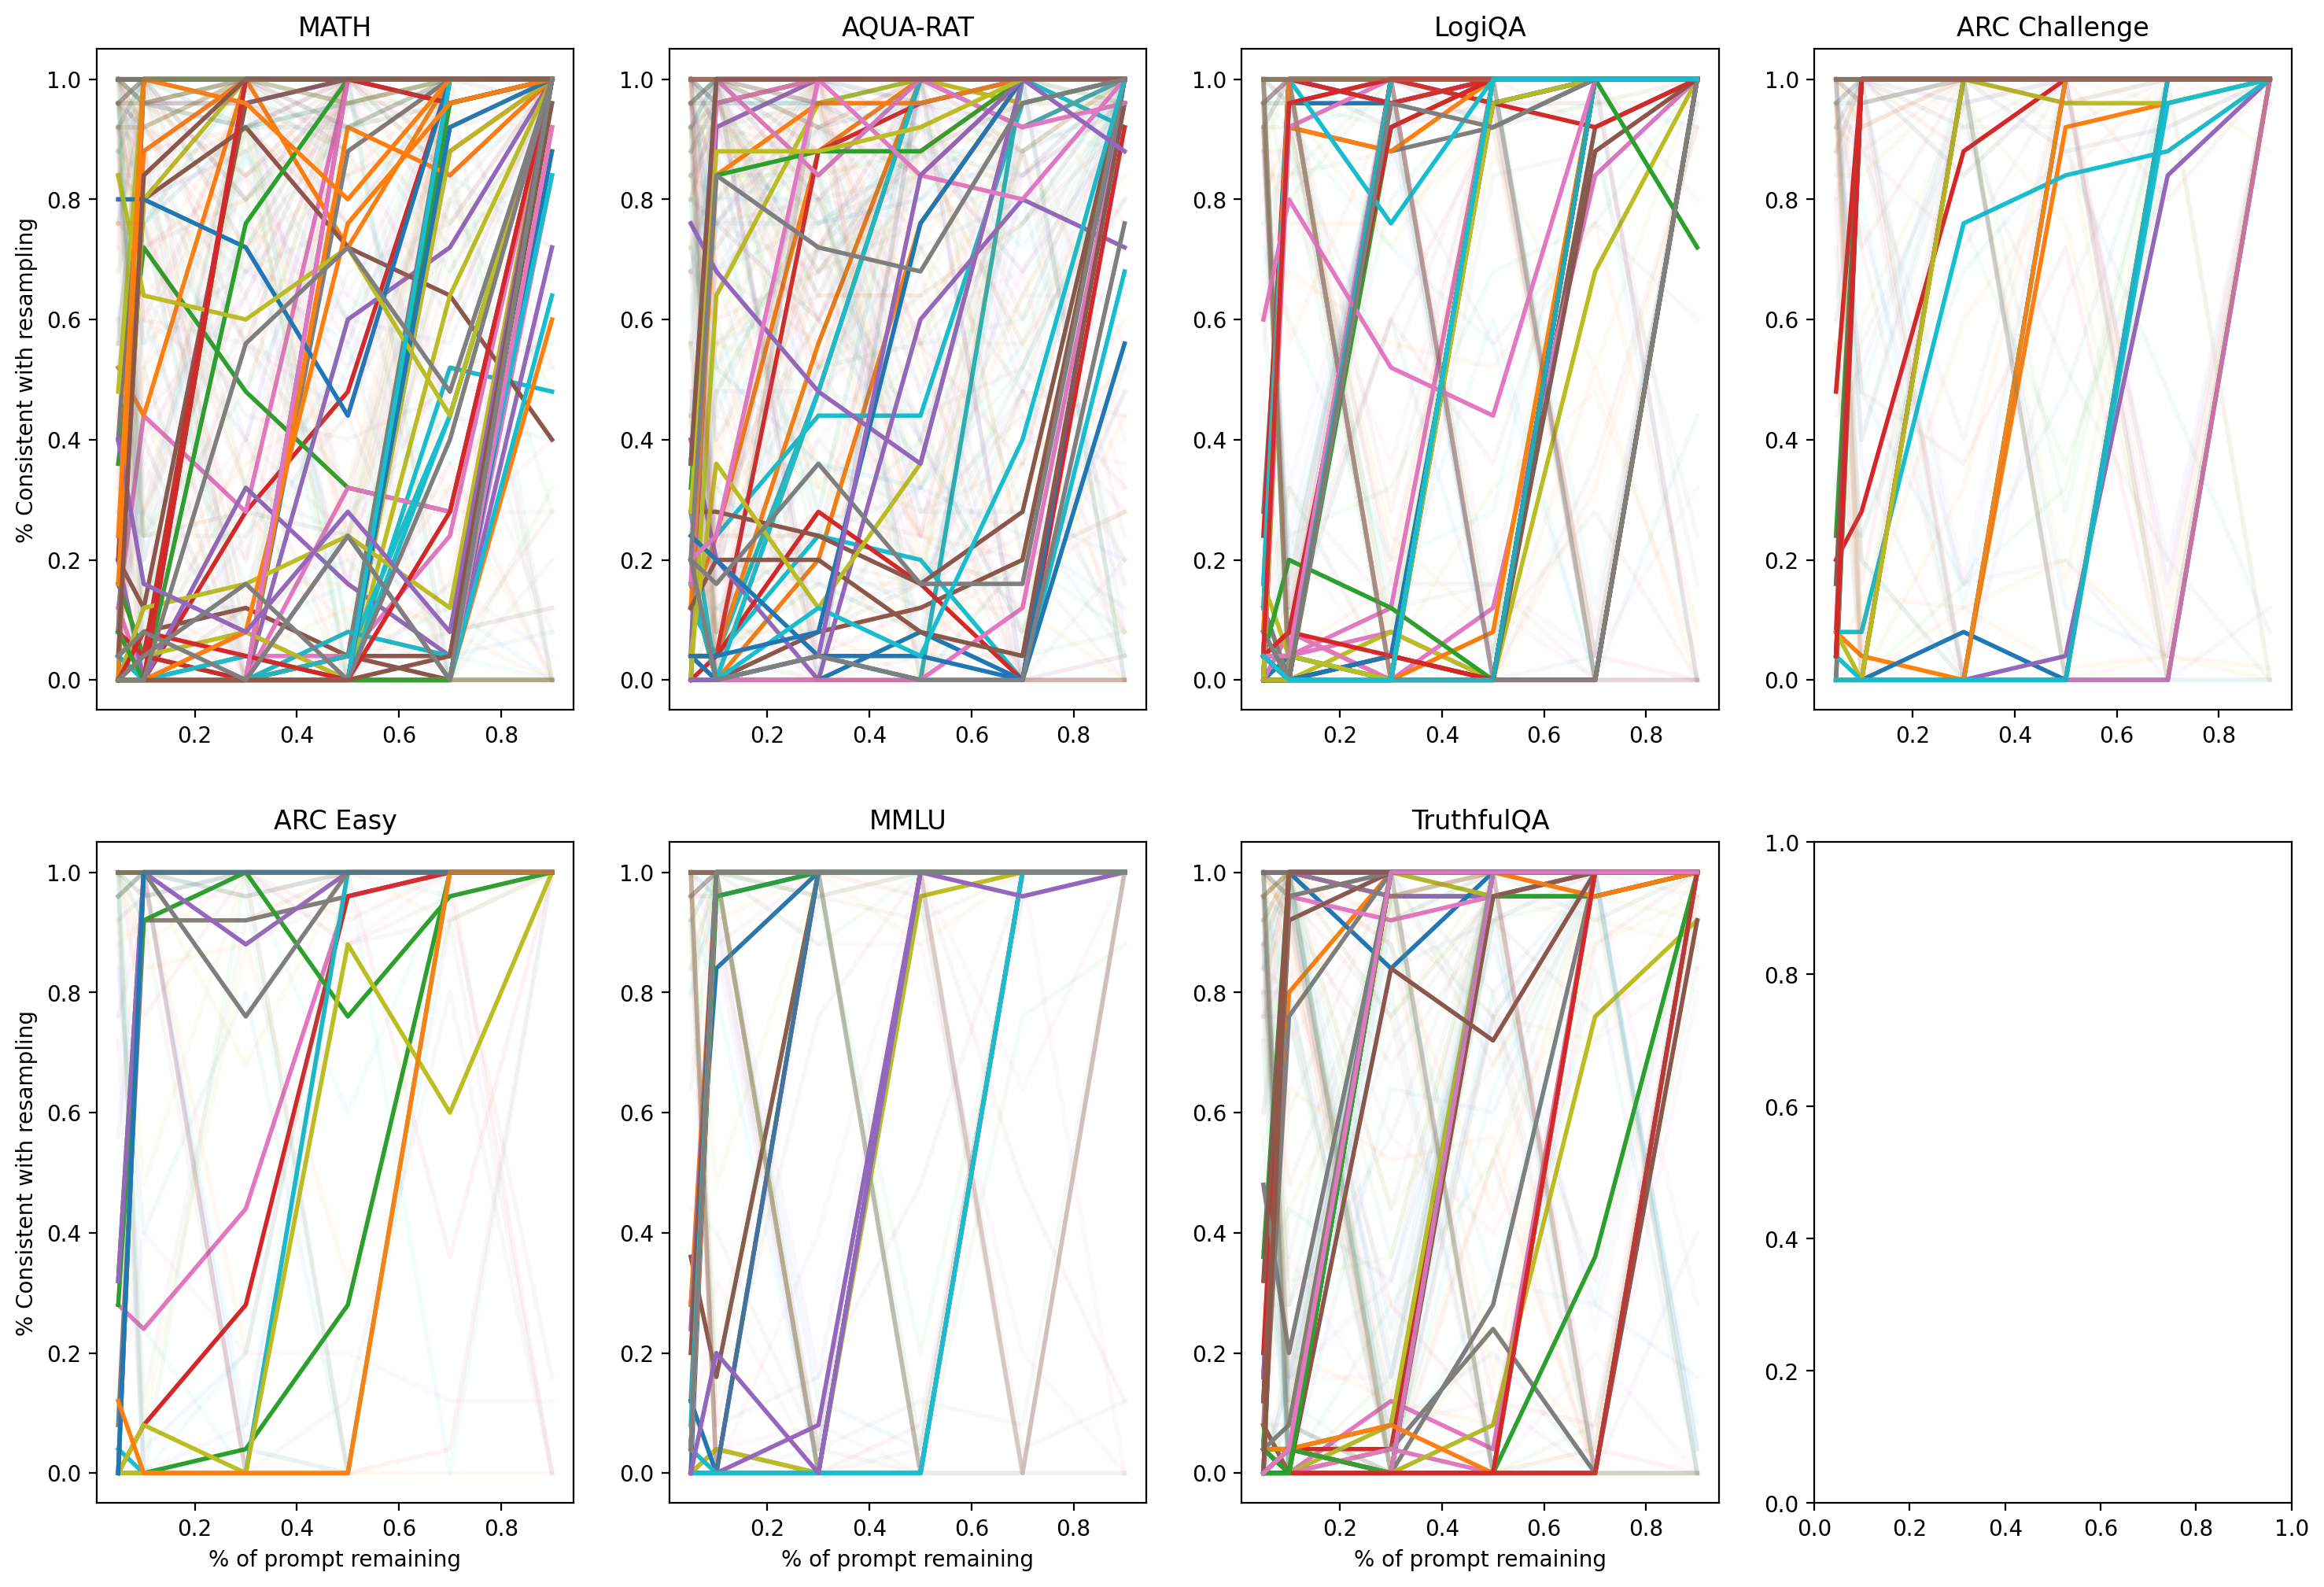

In [18]:
fig, axs = plt.subplots(2,4,dpi=200,figsize=(18, 12))

combined_df["is_cw"] = False 
uniq_datasets = combined_df.dataset_source.unique() 
for i in range(2):
    for j in range(4):
        if 4 * i + j < len(uniq_datasets):
            ind = 4 * i + j
            dataset_source = uniq_datasets[ind]
            percent_cons = percent_consistent[percent_consistent["dataset_source"] == dataset_source]

            for problem in percent_cons["problem"].unique():
                problem_data = percent_cons[percent_cons["problem"] == problem]

                # Get stop_frac and is_consistent values
                stop_frac = problem_data["stop_frac"].values
                is_consistent = problem_data["is_consistent"].values

                # Check for conditions: large jump and monotonic increase
                y_diffs = np.diff(is_consistent)
                has_large_jump = np.any(y_diffs > 0.5)
                is_monotonic = np.all(np.diff(is_consistent) >= -0.3)

                # Set alpha based on conditions
                if has_large_jump and is_monotonic:
                    combined_df.loc[combined_df.problem==problem,"is_cw"] = True
                    alpha_value = 1.0  # Highlight line
                else:
                    alpha_value = 0.05  # Fade out line

                # Plot the entire line
                axs[i][j].plot(
                    stop_frac, 
                    is_consistent, 
                    color=axs[i][j]._get_lines.get_next_color(),
                    alpha=alpha_value,
                    lw=2
                )

            axs[i][j].set_title(f"{dataset_source}")
            if i == 1:
                axs[i][j].set_xlabel("% of prompt remaining")
            if j == 0:
                axs[i][j].set_ylabel("% Consistent with resampling")

### Weird relationship between is_stump and is_consistent

Number of points off the diagonal: 5160


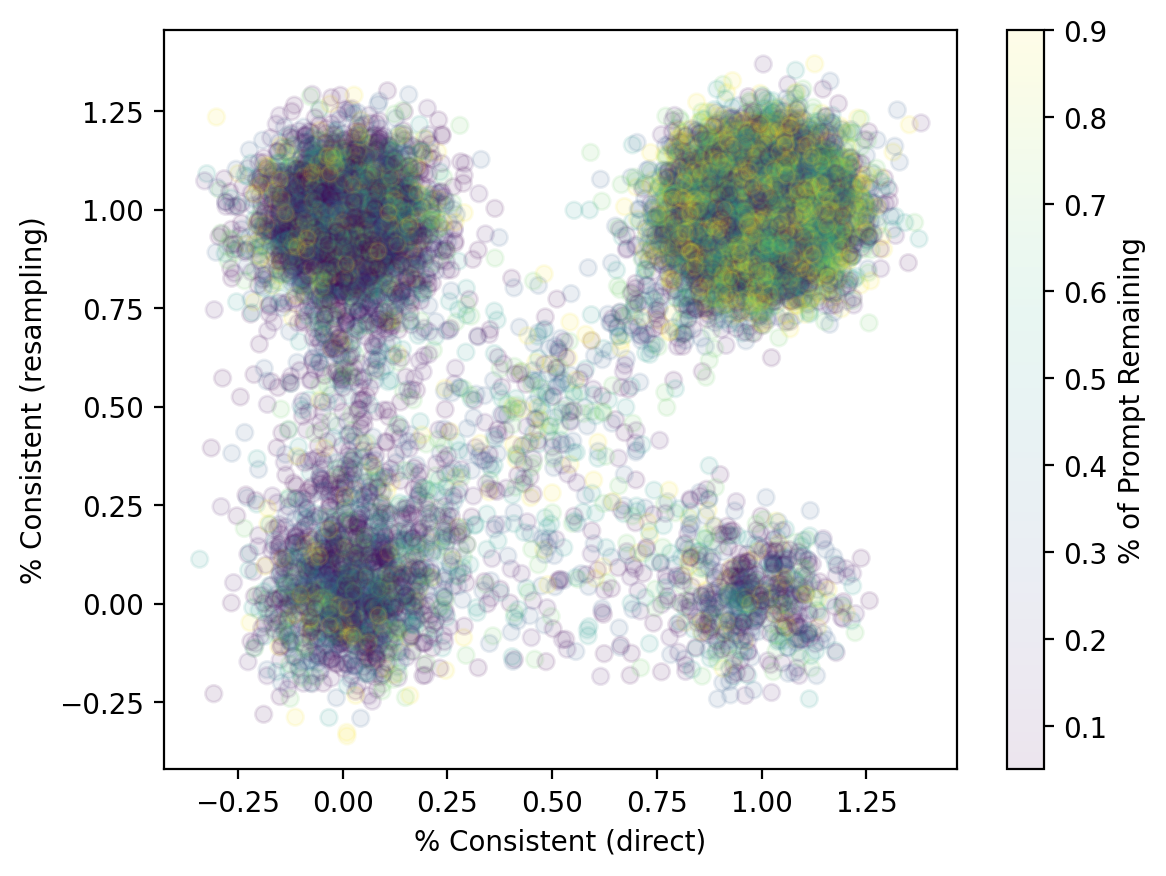

In [19]:
percent_consistent = combined_df.groupby(
    ["dataset_source", "problem", "stop_frac"]
)[["is_consistent", "is_stump"]].mean().reset_index()

# Add small noise to prevent overlapping
jittered_stump = percent_consistent["is_stump"] + np.random.normal(0, 0.1, size=len(percent_consistent))
jittered_consistent = percent_consistent["is_consistent"] + np.random.normal(0, 0.1, size=len(percent_consistent))

plt.figure(dpi=200)
scatter = plt.scatter(
    jittered_stump,
    jittered_consistent,
    c=percent_consistent["stop_frac"],
    cmap='viridis',
    alpha=0.1
)
plt.xlabel("% Consistent (direct)")
plt.ylabel("% Consistent (resampling)")

# Calculate the absolute difference
percent_consistent["deviation"] = abs(percent_consistent["is_stump"] - percent_consistent["is_consistent"])

# Define a threshold for being "on the diagonal"
threshold = 1e-6

# Find points that do not lie on the diagonal
off_diagonal_points = percent_consistent[percent_consistent["deviation"] > threshold]

# Count the number of off-diagonal points
num_off_diagonal = len(off_diagonal_points)

print(f"Number of points off the diagonal: {num_off_diagonal}")
# Add colorbar
colorbar = plt.colorbar(scatter)
colorbar.set_label("% of Prompt Remaining")  # Label for the colorbar


### Analyzing critical windows

In [20]:
combined_df.groupby(["problem","dataset_source"]).is_cw.mean().groupby("dataset_source").mean().reset_index().rename(columns={"is_cw":"freq"})

dataset_source      freq
0       AQUA-RAT  0.100251
1  ARC Challenge  0.062657
2       ARC Easy  0.035000
3         LogiQA  0.230000
4           MATH  0.167920
5           MMLU  0.080000
6     TruthfulQA  0.125000

/tmp/ipykernel_3676006/1135036353.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data_sorted, x='dataset_source', y='freq', palette='viridis')


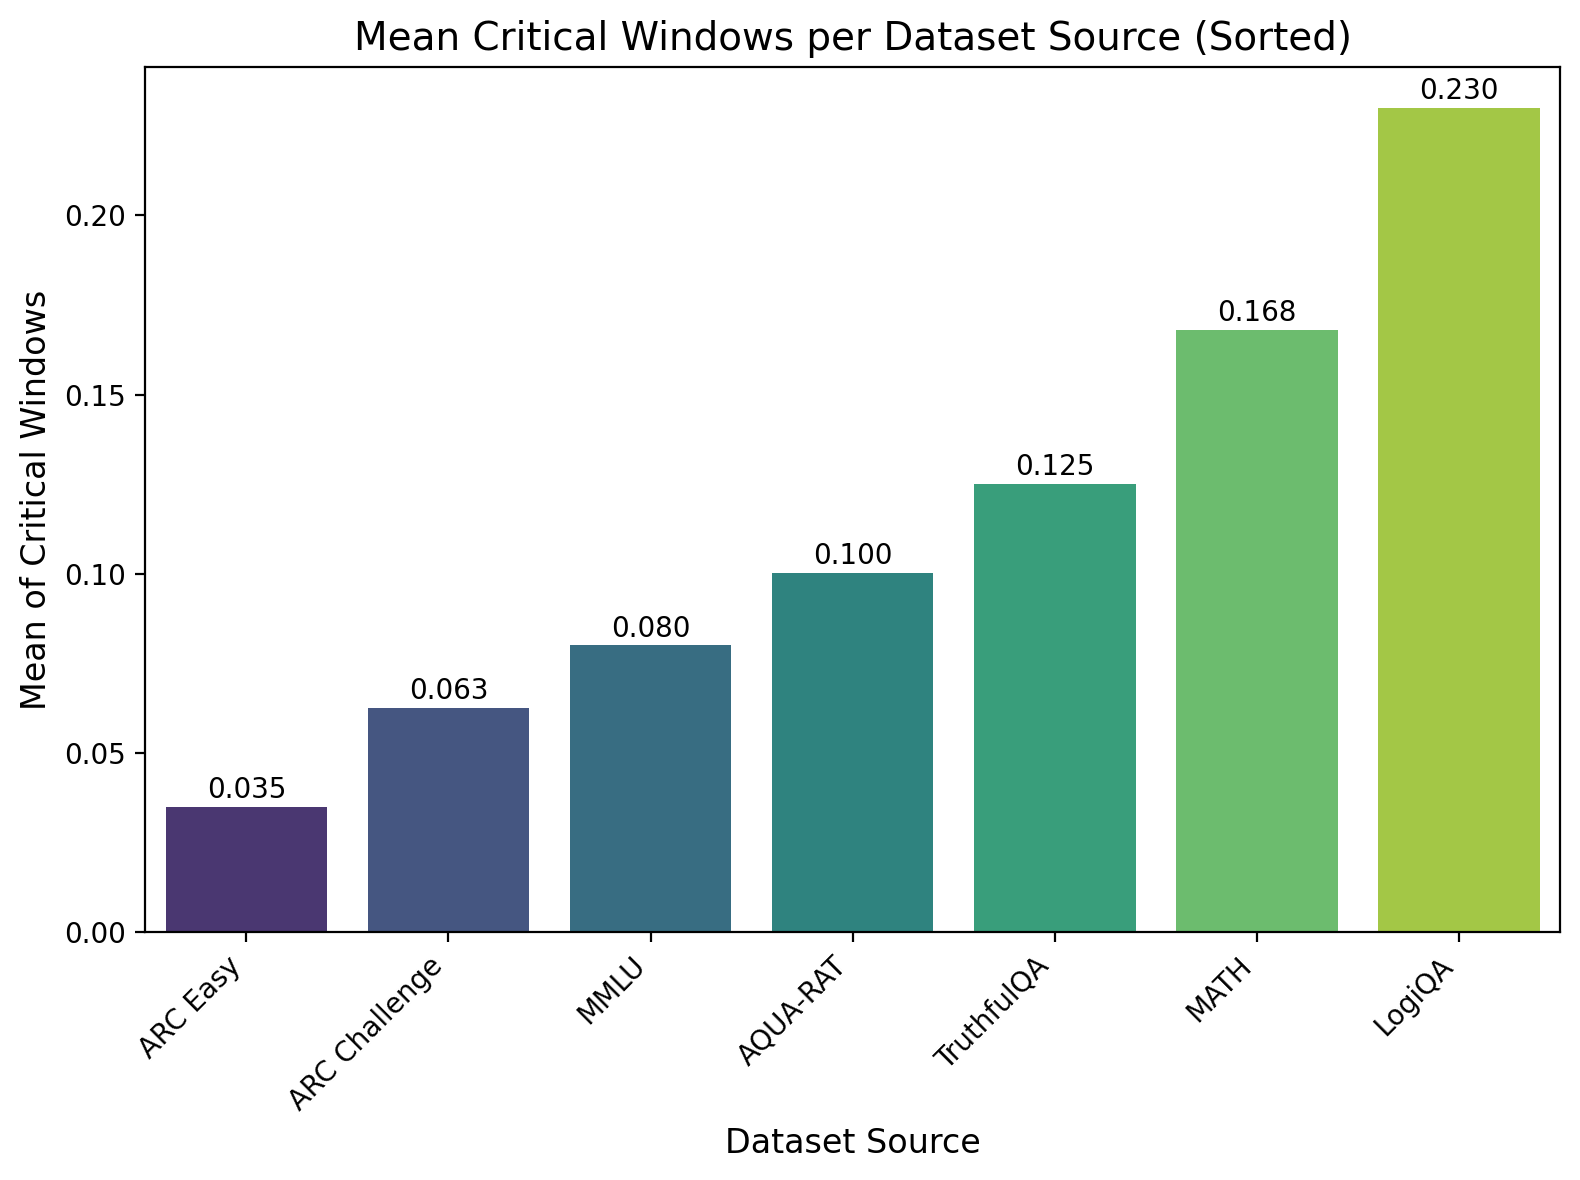

In [21]:
## Number of critical windows per dataset type
data = combined_df.groupby(["problem","dataset_source"]).is_cw.mean().groupby("dataset_source").mean().reset_index().rename(columns={"is_cw":"freq"})

# Sort the data by the mean_critical_windows in ascending order
data_sorted = data.sort_values(by='freq', ascending=True)

# Create a barplot using seaborn
plt.figure(figsize=(8, 6),dpi=200)
sns.barplot(data=data_sorted, x='dataset_source', y='freq', palette='viridis')

# Add labels and title
plt.xlabel('Dataset Source', fontsize=12)
plt.ylabel('Mean of Critical Windows', fontsize=12)
plt.title('Mean Critical Windows per Dataset Source (Sorted)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
for index, row in data_sorted.reset_index().iterrows():
    plt.text(
        x=index, 
        y=row['freq'] + 0.0025,  # Slightly above the bar
        s=f"{row['freq']:.3f}",
        ha='center',
        fontsize=10
    )

plt.tight_layout()
plt.show()

In [22]:
import re
def extract_first_assistant_response(text):
    # Regular expression to find all assistant sections
    matches = re.findall(r"<\|start_header_id\|>assistant<\|end_header_id\|>(.*?)<\|eot_id\|>", text, re.DOTALL)
    # If matches are found, return the last one, stripping any extra whitespace
    if matches:
        return matches[0].strip()
    return None  # Return None if no matches are found

In [32]:
combined_df[["dataset_source","orig_string_ans","no_"]].head(5)

problem formatted_answer  stop_frac  no  \
0  Find $\sec 135^\circ.$        -\sqrt{2}       0.05   0   
1  Find $\sec 135^\circ.$        -\sqrt{2}       0.05   1   
2  Find $\sec 135^\circ.$        -\sqrt{2}       0.05   2   
3  Find $\sec 135^\circ.$        -\sqrt{2}       0.05   3   
4  Find $\sec 135^\circ.$        -\sqrt{2}       0.05   4   

              orig_ans_string orig_ans_format  \
0  The answer is $-\sqrt{2}$.       -\sqrt{2}   
1  The answer is $-\sqrt{2}$.       -\sqrt{2}   
2  The answer is $-\sqrt{2}$.       -\sqrt{2}   
3  The answer is $-\sqrt{2}$.       -\sqrt{2}   
4  The answer is $-\sqrt{2}$.       -\sqrt{2}   

                                    stump_ans_string stump_ans_format  \
0  To find $\sec 135^\circ$, we can use the defin...              NaN   
1  To find $\sec 135^\circ$, we can use the defin...              NaN   
2  To find $\sec 135^\circ$, we can use the defin...              NaN   
3  To find $\sec 135^\circ$, we can use the defin...              NaN   
4  To find $\sec 135^\circ$, we can use the defin...              NaN   

  no_deno_ans_format                  no_deno_ans_string  ...  is_right  \
0          -\sqrt{2}  The answer is $\boxed{-\sqrt{2}}$.  ...      True   
1          -\sqrt{2}          The answer is $-\sqrt{2}$.  ...      True   
2          -\sqrt{2}          The answer is $-\sqrt{2}$.  ...      True   
3          -\sqrt{2}          The answer is $-\sqrt{2}$.  ...      True   
4          -\sqrt{2}          The answer is $-\sqrt{2}$.  ...      True   

   orig_is_right  stump_is_right  is_stump  stump_is_consistent  \
0           True           False     False                False   
1           True           False     False                False   
2           True           False     False                False   
3           True           False     False                False   
4           True           False     False                False   

                                    stump_string_ans  \
0  <|begin_of_text|><|start_header_id|>system<|en...   
1  <|begin_of_text|><|start_header_id|>system<|en...   
2  <|begin_of_text|><|start_header_id|>system<|en...   
3  <|begin_of_text|><|start_header_id|>system<|en...   
4  <|begin_of_text|><|start_header_id|>system<|en...   

                                  no_deno_string_ans  \
0  <|begin_of_text|><|start_header_id|>system<|en...   
1  <|begin_of_text|><|start_header_id|>system<|en...   
2  <|begin_of_text|><|start_header_id|>system<|en...   
3  <|begin_of_text|><|start_header_id|>system<|en...   
4  <|begin_of_text|><|start_header_id|>system<|en...   

                                     orig_string_ans dataset_source  is_cw  
0  <|begin_of_text|><|start_header_id|>system<|en...           MATH  False  
1  <|begin_of_text|><|start_header_id|>system<|en...           MATH  False  
2  <|begin_of_text|><|start_header_id|>system<|en...           MATH  False  
3  <|begin_of_text|><|start_header_id|>system<|en...           MATH  False  
4  <|begin_of_text|><|start_header_id|>system<|en...           MATH  False  

[5 rows x 21 columns]

In [24]:
filtered_problems = combined_df[combined_df['is_cw'] == True]['problem'].unique()

num_problems_to_process = 3  # Adjust this number as needed

for problem in filtered_problems[:num_problems_to_process]:
    # Filter rows for the current problem and sort by stop_frac
    problem_rows = combined_df[combined_df['problem'] == problem].sort_values(by='stop_frac')
    
#     # Print the problem, stripping and replacing \n
#     print(f"{'='*40}")
#     problem_cleaned = problem.strip().replace('\n', '')
#     orig_ans_format_cleaned = problem_rows['orig_ans_format'].iloc[0].strip().replace('\n', '')
#     orig_string_ans_cleaned = problem_rows['orig_string_ans'].iloc[0].strip().replace('\n', '')
#     print(f"Problem: {problem_cleaned} | Original Answer Format: {orig_ans_format_cleaned} \n| Answer : {extract_first_assistant_response(orig_string_ans_cleaned)}")
    
#     # Iterate through rows and print the required columns
#     for _, row in problem_rows.iterrows():
#         stop_frac = row['stop_frac']
#         stump_string_ans = row['stump_string_ans'].strip().replace('\n', '')
#         no_deno_string_ans = row['no_deno_string_ans'].strip().replace('\n', '')
#         print(f"  stop_frac: {stop_frac} \n| stump_string_ans: {extract_first_assistant_response(stump_string_ans)} \n | no_deno_string_ans: {extract_first_assistant_response(no_deno_string_ans)}")
#         # Uncomment the next line to include orig_ans_string
#         # orig_ans_string = row['orig_ans_string'].strip().replace('\n', '')
#         # print(f"  orig_ans_string: {orig_ans_string}")
#     print(f"{'='*40}")

In [29]:
def find_jumps_with_context(df, column_name, jump_threshold, context_column):
    # Sort by the column of interest to ensure proper order
    df = df.sort_values(by=context_column).reset_index(drop=True)
    
    # Calculate the differences between consecutive rows
    df['diff'] = df[column_name].diff()
    
    # Find indices where the difference exceeds the threshold
    jump_indices = df.index[df['diff'].abs() >= jump_threshold].tolist()
    
    # Collect the rows before, at, and after the jump
    rows_with_context = []
    for idx in jump_indices:
        start_idx = max(idx - 1, 0)  # Get the row before, or the first row if out of bounds
        end_idx = min(idx + 1, len(df) - 1)  # Get the row after, or the last row if out of bounds
        rows_with_context.append(df.loc[start_idx:end_idx])
    
    # Combine all the contextual rows into a single DataFrame
    result_df = pd.concat(rows_with_context).drop_duplicates().reset_index(drop=True)
    
    return result_df

# Example usage
# Replace `problem_rows` with your actual DataFrame
jump_threshold = 0.5
context_column = 'stop_frac'  # The column to maintain order
column_of_interest = 'is_consistent'  # The column to check jumps

grouped_df = problem_rows.groupby("stop_frac")["is_consistent"].mean().reset_index()
jumps_with_context = find_jumps_with_context(grouped_df, column_of_interest, jump_threshold, context_column)


In [30]:
jumps_with_context

stop_frac  is_consistent  diff
0       0.05           0.24   NaN
1       0.10           1.00  0.76
2       0.30           0.96 -0.04